In [1]:
from sklearn.preprocessing import MaxAbsScaler
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
'''
load data
'''
original_data_df = pd.read_csv('./data/original_data.csv')

In [3]:
original_data_df.head()

,frontyear,backyear,month,day,location,temp_avg,temp_min,temp_max
0,19,54,1,18,seoul,1.4,-2.2,4.8
1,19,54,1,19,seoul,1.5,-1.3,5.8
2,19,54,1,20,seoul,4.7,-1.5,10.7
3,19,54,1,21,seoul,2.8,0.5,5.5
4,19,54,1,22,seoul,-2.1,-6.4,1.6


In [4]:
original_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24336 entries, 0 to 24335
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   frontyear  24336 non-null  int64  
 1   backyear   24336 non-null  int64  
 2   month      24336 non-null  int64  
 3   day        24336 non-null  int64  
 4   location   24336 non-null  object 
 5   temp_avg   24336 non-null  float64
 6   temp_min   24335 non-null  float64
 7   temp_max   24334 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 1.5+ MB


In [5]:
'''
drop unnecessary column
'''
data_df = original_data_df.drop(['location'], axis = 1)

In [6]:
data_df.head()

,frontyear,backyear,month,day,temp_avg,temp_min,temp_max
0,19,54,1,18,1.4,-2.2,4.8
1,19,54,1,19,1.5,-1.3,5.8
2,19,54,1,20,4.7,-1.5,10.7
3,19,54,1,21,2.8,0.5,5.5
4,19,54,1,22,-2.1,-6.4,1.6


In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24336 entries, 0 to 24335
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   frontyear  24336 non-null  int64  
 1   backyear   24336 non-null  int64  
 2   month      24336 non-null  int64  
 3   day        24336 non-null  int64  
 4   temp_avg   24336 non-null  float64
 5   temp_min   24335 non-null  float64
 6   temp_max   24334 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 1.3 MB


In [8]:
'''
check missing value
'''
data_df.isnull().sum()

frontyear    0
backyear     0
month        0
day          0
temp_avg     0
temp_min     1
temp_max     2
dtype: int64

In [9]:
'''
change missing value to nearby value
'''
data_df = data_df.fillna(method = 'pad')

In [10]:
data_df.isnull().sum()

frontyear    0
backyear     0
month        0
day          0
temp_avg     0
temp_min     0
temp_max     0
dtype: int64

In [11]:
'''
change data type to calculate between components
'''
data_df = data_df.apply(pd.to_numeric)

In [12]:
'''
create new seasonality data from 'month' column and concatenate

Spring: 3 ~ 5 - 0.05
Summer: 6 ~ 8 - 0.25
Fall: 9 ~ 11 - 0.42
Winter: 12 ~ 2 - 0.28
'''
season_data_df = pd.DataFrame(data_df['month'])

In [13]:
season_data_df.head()

,month
0,1
1,1
2,1
3,1
4,1


In [14]:
'''
change column name to season
'''
season_data_df.columns = ['season']

In [15]:
season_data_df.head()

,season
0,1
1,1
2,1
3,1
4,1


In [16]:
'''
concatenate
'''
new_data_df = pd.concat([data_df, season_data_df], axis = 1)

In [17]:
new_data_df.head()

,frontyear,backyear,month,day,temp_avg,temp_min,temp_max,season
0,19,54,1,18,1.4,-2.2,4.8,1
1,19,54,1,19,1.5,-1.3,5.8,1
2,19,54,1,20,4.7,-1.5,10.7,1
3,19,54,1,21,2.8,0.5,5.5,1
4,19,54,1,22,-2.1,-6.4,1.6,1


In [18]:
new_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24336 entries, 0 to 24335
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   frontyear  24336 non-null  int64  
 1   backyear   24336 non-null  int64  
 2   month      24336 non-null  int64  
 3   day        24336 non-null  int64  
 4   temp_avg   24336 non-null  float64
 5   temp_min   24336 non-null  float64
 6   temp_max   24336 non-null  float64
 7   season     24336 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 1.5 MB


In [19]:
'''
cluster seasonality data
'''
for season in new_data_df:
    new_data_df.loc[(new_data_df['season'] >= 1) & (new_data_df['season'] < 3), 'season'] = 0.05
    new_data_df.loc[(new_data_df['season'] >= 3) & (new_data_df['season'] < 6), 'season'] = 0.25
    new_data_df.loc[(new_data_df['season'] >= 6) & (new_data_df['season'] < 9), 'season'] = 0.42
    new_data_df.loc[(new_data_df['season'] >= 9) & (new_data_df['season'] < 12), 'season'] = 0.28
    new_data_df.loc[(new_data_df['season'] >= 12), 'season'] = 0.05

In [20]:
new_data_df.head()

,frontyear,backyear,month,day,temp_avg,temp_min,temp_max,season
0,19,54,1,18,1.4,-2.2,4.8,0.05
1,19,54,1,19,1.5,-1.3,5.8,0.05
2,19,54,1,20,4.7,-1.5,10.7,0.05
3,19,54,1,21,2.8,0.5,5.5,0.05
4,19,54,1,22,-2.1,-6.4,1.6,0.05


In [21]:
'''
data scaling
'''
scaler = MaxAbsScaler()

In [22]:
scaled_data_df = pd.DataFrame(scaler.fit_transform(new_data_df))
scaled_data_df.columns = ['frontyear', 'backyear', 'month', 'day', 'temp_avg', 'temp_min', 'temp_max', 'season']

In [23]:
scaled_data_df.head()

,frontyear,backyear,month,day,temp_avg,temp_min,temp_max,season
0,0.95,0.545455,0.083333,0.580645,0.041543,-0.072607,0.121212,0.119048
1,0.95,0.545455,0.083333,0.612903,0.044510,-0.042904,0.146465,0.119048
2,0.95,0.545455,0.083333,0.645161,0.139466,-0.049505,0.270202,0.119048
3,0.95,0.545455,0.083333,0.677419,0.083086,0.016502,0.138889,0.119048
4,0.95,0.545455,0.083333,0.709677,-0.062315,-0.211221,0.040404,0.119048


In [24]:
scaled_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24336 entries, 0 to 24335
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   frontyear  24336 non-null  float64
 1   backyear   24336 non-null  float64
 2   month      24336 non-null  float64
 3   day        24336 non-null  float64
 4   temp_avg   24336 non-null  float64
 5   temp_min   24336 non-null  float64
 6   temp_max   24336 non-null  float64
 7   season     24336 non-null  float64
dtypes: float64(8)
memory usage: 1.5 MB


In [25]:
'''
seperate to train, validation, test data
'''
total_size = int(len(scaled_data_df))

train_data_df = scaled_data_df[0:int(total_size * 0.7)].reset_index(drop = True)
validation_data_df = scaled_data_df[:int(total_size * 0.15):].reset_index(drop = True)
test_data_df = scaled_data_df[int(total_size * 0.85):].reset_index(drop = True)

In [26]:
'''
calculate data size
'''
print("Total Length: {}".format(len(scaled_data_df)))
print("Train Length: {} | Validation Length: {} | Test Length: {}".format(len(train_data_df), len(validation_data_df), len(test_data_df)))
print("{} + {} + {} = {}".format(len(train_data_df), len(validation_data_df), len(test_data_df), len(train_data_df) + len(validation_data_df) + len(test_data_df)))

Total Length: 24336
Train Length: 17035 | Validation Length: 3650 | Test Length: 3651
17035 + 3650 + 3651 = 24336


In [27]:
'''
check data shape, eight features
'''
print("Total Length: {}".format(total_size))
print("Total DataFrame Shape: {}".format(scaled_data_df.shape))
print("Train DataFrame Shape: {}".format(train_data_df.shape))
print("Validation DataFrame Shape: {}".format(validation_data_df.shape))
print("Test DataFrame Shape: {}".format(test_data_df.shape))

Total Length: 24336
Total DataFrame Shape: (24336, 8)
Train DataFrame Shape: (17035, 8)
Validation DataFrame Shape: (3650, 8)
Test DataFrame Shape: (3651, 8)


In [28]:
'''
seperate to input, target data
'''
input_feature_list = ['frontyear', 'backyear', 'month', 'day', 'season']
target_feature_list = ['temp_avg', 'temp_min', 'temp_max']

x_train_data_df = train_data_df[input_feature_list]
y_train_data_df = train_data_df[target_feature_list]
x_validation_data_df = validation_data_df[input_feature_list]
y_validation_data_df = validation_data_df[target_feature_list]
x_test_data_df = test_data_df[input_feature_list]
y_test_data_df = test_data_df[target_feature_list]

In [29]:
'''
check seperated data shape, five-three features
'''
print("X Train DataFrame Shape: {}".format(x_train_data_df.shape))
print("Y Train DataFrame Shape: {}".format(y_train_data_df.shape))
print("X Validation DataFrame Shape: {}".format(x_validation_data_df.shape))
print("Y Validation DataFrame Shape: {}".format(y_validation_data_df.shape))
print("X Test DataFrame Shape: {}".format(x_test_data_df.shape))
print("Y Test DataFrame Shape: {}".format(y_test_data_df.shape))

X Train DataFrame Shape: (17035, 5)
Y Train DataFrame Shape: (17035, 3)
X Validation DataFrame Shape: (3650, 5)
Y Validation DataFrame Shape: (3650, 3)
X Test DataFrame Shape: (3651, 5)
Y Test DataFrame Shape: (3651, 3)


In [30]:
'''
gpu setting
'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
print("{} has been operated".format(device))

cuda has been operated


In [32]:
'''
fix random seed
'''
torch.manual_seed(515)

In [33]:
'''
hyperparameter setting

input shape : (batch size, sequence length, input dimension)
'''
num_years = 21
batch_size = 12 * num_years # 21years data every batch
sequence_length = 1
input_size = 5 # input data has five features
hidden_size = 32
num_layers = 3
output_size = 3 # output data has three features
learning_rate = 1e-5
max_norm = 5 # gradient clipping
nb_epochs = 1000

In [34]:
'''
define dataset function
'''
def MakeDataSet(x_data_df, y_data_df):
    x_ts = torch.FloatTensor(np.array(x_data_df))
    y_ts = torch.FloatTensor(np.array(y_data_df))
    dataset_ts = TensorDataset(x_ts, y_ts)
    return dataset_ts

In [35]:
'''
define dataloader function
'''
def MakeDataLoader(dataset, batch_size):
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
    return dataloader

In [64]:
'''
create dataset
'''
train_dataset_ts = MakeDataSet(x_train_data_df, y_train_data_df)
validation_dataset_ts = MakeDataSet(x_validation_data_df, y_validation_data_df)
test_dataset_ts = MakeDataSet(x_test_data_df, y_test_data_df)

In [65]:
'''
create dataloader
'''
train_dataloader = MakeDataLoader(train_dataset_ts, batch_size)
validation_dataloader = MakeDataLoader(validation_dataset_ts, batch_size)
test_dataloader = MakeDataLoader(test_dataset_ts, batch_size)

In [38]:
'''
check data to be used
'''
for index, value in enumerate(train_dataloader):
    while index < 6:
        x, y = value
        print("{} Batch".format(index))
        print("Input: {}".format(x.shape))
        print("Target: {}".format(y.shape))
        
        break    

0 Batch
Input: torch.Size([252, 5])
Target: torch.Size([252, 3])
1 Batch
Input: torch.Size([252, 5])
Target: torch.Size([252, 3])
2 Batch
Input: torch.Size([252, 5])
Target: torch.Size([252, 3])
3 Batch
Input: torch.Size([252, 5])
Target: torch.Size([252, 3])
4 Batch
Input: torch.Size([252, 5])
Target: torch.Size([252, 3])
5 Batch
Input: torch.Size([252, 5])
Target: torch.Size([252, 3])


In [39]:
'''
define model layer, forward pass
'''
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(BiLSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            dropout = 0.3,
            batch_first = True,
            bidirectional = True)
        
        self.fc = nn.Linear(
            in_features = hidden_size * 2, 
            out_features = output_size, 
            bias = True)
        
    def forward(self, x):
        # init hidden and cell state
        hidden_state_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        cell_state_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        
        # forward pass
        out, _ = self.lstm(x, (hidden_state_0, cell_state_0))
        out = self.fc(out[:, -1, :])
        
        return out

In [40]:
'''
define model, cost function, optimizer
'''
model = BiLSTM(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1e-5)

In [41]:
print(model)
print(criterion)
print(optimizer)

BiLSTM(
  (lstm): LSTM(5, 32, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)
MSELoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 1e-05
)


In [42]:
'''
model test
'''
x, y = list(train_dataloader)[0]
x = x.view(-1, sequence_length, input_size).to(device)
y = y.to(device)
hypothesis = model(x)
loss = criterion(hypothesis, y)

In [43]:
print("x: {} | {} | x dimension: {}".format(x[0], x.shape, x.dim()))
print("y: {} | {} | y dimension: {}".format(y[0], y.shape, y.dim()))
print("hypothesis: {} | {}".format(hypothesis.shape, hypothesis.dim()))
print("loss: {}".format(loss))

x: tensor([[0.9500, 0.6061, 0.4167, 0.9355, 0.5952]], device='cuda:0') | torch.Size([252, 1, 5]) | x dimension: 3
y: tensor([0.5312, 0.4323, 0.5909], device='cuda:0') | torch.Size([252, 3]) | y dimension: 2
hypothesis: torch.Size([252, 3]) | 2
loss: 0.176507830619812


In [56]:
'''
train
'''
trn_loss_list = []
val_loss_list = []
for epoch in range(nb_epochs):
    
    # Train
    trn_loss = 0.0
    for i, train_samples in enumerate(train_dataloader):
        
        # train data setting
        x_train, y_train = train_samples
        x_train = x_train.view(-1, sequence_length, input_size).to(device)
        y_train = y_train.to(device)
        
        # train
        model.train()
        hypothesis = model(x_train)
        optimizer.zero_grad()
        train_loss = criterion(hypothesis, y_train)
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
        
        # train loss
        trn_loss += train_loss.item() / len(train_dataloader)
    
    trn_loss_list.append(trn_loss)
    
    # Evaluation
    with torch.no_grad():
        val_loss = 0.0
        for j, validation_samples in enumerate(validation_dataloader):
            
            # validatoin data setting
            x_validation, y_validation = validation_samples
            x_validation = x_validation.view(-1, sequence_length, input_size).to(device)
            y_validation = y_validation.to(device)
            
            # evaluation
            model.eval()
            prediction = model(x_validation)
            validation_loss = criterion(prediction, y_validation)
            
            # validation loss
            val_loss += validation_loss.item() / len(validation_dataloader)
    val_loss_list.append(val_loss)
    
    print("Epoch: {:3d} | Train Loss: {:.6f} | Val Loss: {:.6f}".format(epoch + 1, trn_loss, val_loss))

torch.save(model, './data/temperature_model.pt')

Epoch:   1 | Train Loss: 0.192671 | Val Loss: 0.184766
Epoch:   2 | Train Loss: 0.190162 | Val Loss: 0.182522
Epoch:   3 | Train Loss: 0.188106 | Val Loss: 0.181355
Epoch:   4 | Train Loss: 0.185787 | Val Loss: 0.178779
Epoch:   5 | Train Loss: 0.183513 | Val Loss: 0.176663
Epoch:   6 | Train Loss: 0.181243 | Val Loss: 0.174542
Epoch:   7 | Train Loss: 0.179059 | Val Loss: 0.171976
Epoch:   8 | Train Loss: 0.176398 | Val Loss: 0.170743
Epoch:   9 | Train Loss: 0.173875 | Val Loss: 0.167671
Epoch:  10 | Train Loss: 0.171416 | Val Loss: 0.165000
Epoch:  11 | Train Loss: 0.168518 | Val Loss: 0.161840
Epoch:  12 | Train Loss: 0.165746 | Val Loss: 0.160033
Epoch:  13 | Train Loss: 0.162915 | Val Loss: 0.156552
Epoch:  14 | Train Loss: 0.160015 | Val Loss: 0.153944
Epoch:  15 | Train Loss: 0.156861 | Val Loss: 0.151673
Epoch:  16 | Train Loss: 0.153683 | Val Loss: 0.148600
Epoch:  17 | Train Loss: 0.150366 | Val Loss: 0.144454
Epoch:  18 | Train Loss: 0.147020 | Val Loss: 0.141286
Epoch:  19

Epoch: 150 | Train Loss: 0.032350 | Val Loss: 0.028644
Epoch: 151 | Train Loss: 0.032468 | Val Loss: 0.028658
Epoch: 152 | Train Loss: 0.032257 | Val Loss: 0.028522
Epoch: 153 | Train Loss: 0.032136 | Val Loss: 0.028402
Epoch: 154 | Train Loss: 0.032103 | Val Loss: 0.028394
Epoch: 155 | Train Loss: 0.031738 | Val Loss: 0.028197
Epoch: 156 | Train Loss: 0.031939 | Val Loss: 0.028086
Epoch: 157 | Train Loss: 0.031722 | Val Loss: 0.028022
Epoch: 158 | Train Loss: 0.031641 | Val Loss: 0.028056
Epoch: 159 | Train Loss: 0.031595 | Val Loss: 0.028105
Epoch: 160 | Train Loss: 0.031459 | Val Loss: 0.027798
Epoch: 161 | Train Loss: 0.031552 | Val Loss: 0.027933
Epoch: 162 | Train Loss: 0.031561 | Val Loss: 0.027866
Epoch: 163 | Train Loss: 0.031470 | Val Loss: 0.027621
Epoch: 164 | Train Loss: 0.031245 | Val Loss: 0.027516
Epoch: 165 | Train Loss: 0.031659 | Val Loss: 0.027606
Epoch: 166 | Train Loss: 0.031144 | Val Loss: 0.027764
Epoch: 167 | Train Loss: 0.031389 | Val Loss: 0.027719
Epoch: 168

Epoch: 299 | Train Loss: 0.027968 | Val Loss: 0.026675
Epoch: 300 | Train Loss: 0.028015 | Val Loss: 0.026542
Epoch: 301 | Train Loss: 0.027946 | Val Loss: 0.026545
Epoch: 302 | Train Loss: 0.028021 | Val Loss: 0.026708
Epoch: 303 | Train Loss: 0.028165 | Val Loss: 0.026444
Epoch: 304 | Train Loss: 0.027941 | Val Loss: 0.026554
Epoch: 305 | Train Loss: 0.028037 | Val Loss: 0.026649
Epoch: 306 | Train Loss: 0.028114 | Val Loss: 0.026621
Epoch: 307 | Train Loss: 0.028057 | Val Loss: 0.026554
Epoch: 308 | Train Loss: 0.027978 | Val Loss: 0.026593
Epoch: 309 | Train Loss: 0.027930 | Val Loss: 0.026707
Epoch: 310 | Train Loss: 0.027884 | Val Loss: 0.026638
Epoch: 311 | Train Loss: 0.027991 | Val Loss: 0.026565
Epoch: 312 | Train Loss: 0.028092 | Val Loss: 0.026522
Epoch: 313 | Train Loss: 0.028057 | Val Loss: 0.026615
Epoch: 314 | Train Loss: 0.027834 | Val Loss: 0.026648
Epoch: 315 | Train Loss: 0.027995 | Val Loss: 0.026479
Epoch: 316 | Train Loss: 0.028123 | Val Loss: 0.026375
Epoch: 317

Epoch: 448 | Train Loss: 0.027058 | Val Loss: 0.026232
Epoch: 449 | Train Loss: 0.027108 | Val Loss: 0.026311
Epoch: 450 | Train Loss: 0.027102 | Val Loss: 0.026388
Epoch: 451 | Train Loss: 0.027063 | Val Loss: 0.026456
Epoch: 452 | Train Loss: 0.026929 | Val Loss: 0.026451
Epoch: 453 | Train Loss: 0.027140 | Val Loss: 0.026379
Epoch: 454 | Train Loss: 0.027152 | Val Loss: 0.026286
Epoch: 455 | Train Loss: 0.027096 | Val Loss: 0.026444
Epoch: 456 | Train Loss: 0.027004 | Val Loss: 0.026280
Epoch: 457 | Train Loss: 0.027056 | Val Loss: 0.026349
Epoch: 458 | Train Loss: 0.027000 | Val Loss: 0.026262
Epoch: 459 | Train Loss: 0.027014 | Val Loss: 0.026179
Epoch: 460 | Train Loss: 0.027082 | Val Loss: 0.026394
Epoch: 461 | Train Loss: 0.027144 | Val Loss: 0.026312
Epoch: 462 | Train Loss: 0.027082 | Val Loss: 0.026319
Epoch: 463 | Train Loss: 0.027048 | Val Loss: 0.026414
Epoch: 464 | Train Loss: 0.027081 | Val Loss: 0.026244
Epoch: 465 | Train Loss: 0.026963 | Val Loss: 0.026308
Epoch: 466

Epoch: 597 | Train Loss: 0.026544 | Val Loss: 0.026294
Epoch: 598 | Train Loss: 0.026591 | Val Loss: 0.026252
Epoch: 599 | Train Loss: 0.026707 | Val Loss: 0.026113
Epoch: 600 | Train Loss: 0.026674 | Val Loss: 0.025914
Epoch: 601 | Train Loss: 0.026560 | Val Loss: 0.026076
Epoch: 602 | Train Loss: 0.026648 | Val Loss: 0.025922
Epoch: 603 | Train Loss: 0.026625 | Val Loss: 0.026012
Epoch: 604 | Train Loss: 0.026571 | Val Loss: 0.026011
Epoch: 605 | Train Loss: 0.026664 | Val Loss: 0.026193
Epoch: 606 | Train Loss: 0.026601 | Val Loss: 0.025948
Epoch: 607 | Train Loss: 0.026665 | Val Loss: 0.025871
Epoch: 608 | Train Loss: 0.026534 | Val Loss: 0.025973
Epoch: 609 | Train Loss: 0.026603 | Val Loss: 0.026176
Epoch: 610 | Train Loss: 0.026577 | Val Loss: 0.025885
Epoch: 611 | Train Loss: 0.026615 | Val Loss: 0.025982
Epoch: 612 | Train Loss: 0.026501 | Val Loss: 0.026025
Epoch: 613 | Train Loss: 0.026497 | Val Loss: 0.025910
Epoch: 614 | Train Loss: 0.026525 | Val Loss: 0.026080
Epoch: 615

Epoch: 746 | Train Loss: 0.026031 | Val Loss: 0.025902
Epoch: 747 | Train Loss: 0.026228 | Val Loss: 0.025781
Epoch: 748 | Train Loss: 0.026145 | Val Loss: 0.025782
Epoch: 749 | Train Loss: 0.026328 | Val Loss: 0.025618
Epoch: 750 | Train Loss: 0.026127 | Val Loss: 0.025893
Epoch: 751 | Train Loss: 0.026116 | Val Loss: 0.025660
Epoch: 752 | Train Loss: 0.026261 | Val Loss: 0.025758
Epoch: 753 | Train Loss: 0.026178 | Val Loss: 0.025761
Epoch: 754 | Train Loss: 0.026079 | Val Loss: 0.025628
Epoch: 755 | Train Loss: 0.026215 | Val Loss: 0.025752
Epoch: 756 | Train Loss: 0.026208 | Val Loss: 0.025817
Epoch: 757 | Train Loss: 0.026167 | Val Loss: 0.025688
Epoch: 758 | Train Loss: 0.026268 | Val Loss: 0.025877
Epoch: 759 | Train Loss: 0.025981 | Val Loss: 0.025648
Epoch: 760 | Train Loss: 0.026214 | Val Loss: 0.025777
Epoch: 761 | Train Loss: 0.026091 | Val Loss: 0.025672
Epoch: 762 | Train Loss: 0.026047 | Val Loss: 0.025724
Epoch: 763 | Train Loss: 0.026129 | Val Loss: 0.025638
Epoch: 764

Epoch: 895 | Train Loss: 0.025904 | Val Loss: 0.025661
Epoch: 896 | Train Loss: 0.025815 | Val Loss: 0.025448
Epoch: 897 | Train Loss: 0.025826 | Val Loss: 0.025198
Epoch: 898 | Train Loss: 0.025799 | Val Loss: 0.025387
Epoch: 899 | Train Loss: 0.025817 | Val Loss: 0.025411
Epoch: 900 | Train Loss: 0.025833 | Val Loss: 0.025428
Epoch: 901 | Train Loss: 0.025817 | Val Loss: 0.025523
Epoch: 902 | Train Loss: 0.025785 | Val Loss: 0.025563
Epoch: 903 | Train Loss: 0.025719 | Val Loss: 0.025361
Epoch: 904 | Train Loss: 0.025692 | Val Loss: 0.025351
Epoch: 905 | Train Loss: 0.025758 | Val Loss: 0.025493
Epoch: 906 | Train Loss: 0.025823 | Val Loss: 0.025280
Epoch: 907 | Train Loss: 0.025688 | Val Loss: 0.025434
Epoch: 908 | Train Loss: 0.025783 | Val Loss: 0.025458
Epoch: 909 | Train Loss: 0.025802 | Val Loss: 0.025514
Epoch: 910 | Train Loss: 0.025855 | Val Loss: 0.025434
Epoch: 911 | Train Loss: 0.025713 | Val Loss: 0.025260
Epoch: 912 | Train Loss: 0.025771 | Val Loss: 0.025319
Epoch: 913

In [57]:
'''
train, validation loss
'''
print("train loss list length:", len(trn_loss_list))
print("validation loss list length:", len(val_loss_list))

train loss list length: 1000
validation loss list length: 1000


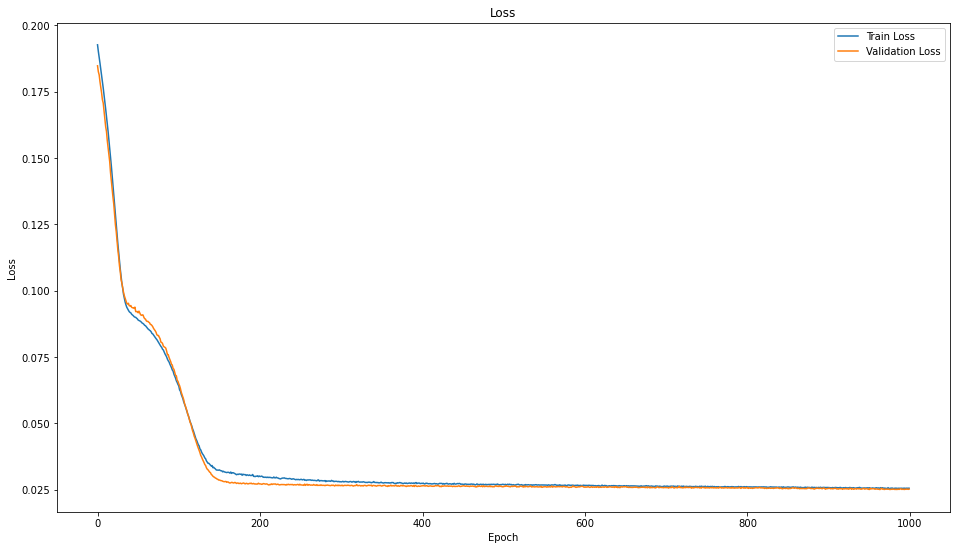

In [60]:
'''
visualization train, validation loss
'''
plt.figure(figsize = (16, 9))
plt.plot(trn_loss_list, label = 'Train Loss')
plt.plot(val_loss_list, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

In [66]:
'''
test
'''
original = []
result = []
for i, batch in enumerate(test_dataloader):
    x, y = batch
    x = x.view(-1, sequence_length, input_size).to(device)
    y = y.to(device)
    pred = model(x)
    label = y
    loss = criterion(pred, label)
    original.append(y.tolist())
    result.append(pred.tolist())
    
print(len(result))
print(len(original))

test_original_np = np.array(sum(sum(original, []), []))
test_result_np = np.array(sum(sum(result, []), []))

15
15


In [67]:
'''
reshape dataframe
'''
test_original_df = pd.DataFrame(test_original_np.reshape(-1, 3))
test_result_df = pd.DataFrame(test_result_np.reshape(-1, 3))

print(test_original_df.shape)
print(test_result_df.shape)

(3651, 3)
(3651, 3)


In [68]:
'''
concatenate each result dataframe
'''
reshaped_test_original_df = pd.concat([x_test_data_df, test_original_df], axis = 1)
reshaped_test_result_df = pd.concat([x_test_data_df, test_result_df], axis = 1)

In [69]:
'''
change each column's location
'''
reshaped_test_original_df.info
reshaped_test_original_df.columns = ['frontyear', 'backyear', 'month', 'day', 'season', 'O_temp_avg', 'O_temp_min', 'O_temp_max']
reshaped_test_result_df.columns = ['frontyear', 'backyear', 'month', 'day', 'season', 'R_temp_avg', 'R_temp_min', 'R_temp_max']

reshaped_test_original_df = reshaped_test_original_df[['frontyear', 'backyear', 'month', 'day', 'O_temp_avg', 'O_temp_min', 'O_temp_max', 'season']]
reshaped_test_result_df = reshaped_test_result_df[['frontyear', 'backyear', 'month', 'day', 'R_temp_avg', 'R_temp_min', 'R_temp_max', 'season']]

In [70]:
print(reshaped_test_original_df.head())
print(reshaped_test_result_df.head())

   frontyear  backyear  month       day  O_temp_avg  O_temp_min  O_temp_max  \
0        1.0   0.10101   0.75  0.193548    0.353116    0.221122    0.398990   
1        1.0   0.10101   0.75  0.225806   -0.011869   -0.141914    0.133838   
2        1.0   0.10101   0.75  0.258065    0.477745    0.376238    0.540404   
3        1.0   0.10101   0.75  0.290323    0.540059    0.511551    0.535354   
4        1.0   0.10101   0.75  0.322581    0.038576   -0.089109    0.229798   

     season  
0  0.666667  
1  0.666667  
2  0.666667  
3  0.666667  
4  0.666667  
   frontyear  backyear  month       day  R_temp_avg  R_temp_min  R_temp_max  \
0        1.0   0.10101   0.75  0.193548    0.304982    0.196540    0.387315   
1        1.0   0.10101   0.75  0.225806   -0.082302   -0.218089    0.038632   
2        1.0   0.10101   0.75  0.258065    0.308117    0.199952    0.389615   
3        1.0   0.10101   0.75  0.290323    0.403575    0.307545    0.470256   
4        1.0   0.10101   0.75  0.322581    0.3

In [72]:
'''
reverse predicted dataframe
'''
inversed_test_original_np = scaler.inverse_transform(reshaped_test_original_df)
inversed_test_original_df = pd.DataFrame(inversed_test_original_np)

inversed_test_result_np = scaler.inverse_transform(reshaped_test_result_df)
inversed_test_result_df = pd.DataFrame(inversed_test_result_np)

In [73]:
'''
change each column's location
'''
inversed_test_original_df.columns = [['frontyear', 'backyear', 'month', 'day', 'O_temp_avg', 'O_temp_min', 'O_temp_max', 'season']]
inversed_test_result_df.columns = [['frontyear', 'backyear', 'month', 'day', 'P_temp_avg', 'P_temp_min', 'P_temp_max', 'season']]

dropped_test_original_df = inversed_test_original_df[['O_temp_avg', 'O_temp_min', 'O_temp_max']]
dropped_test_result_df = inversed_test_result_df[['P_temp_avg', 'P_temp_min', 'P_temp_max']]

Average temperature


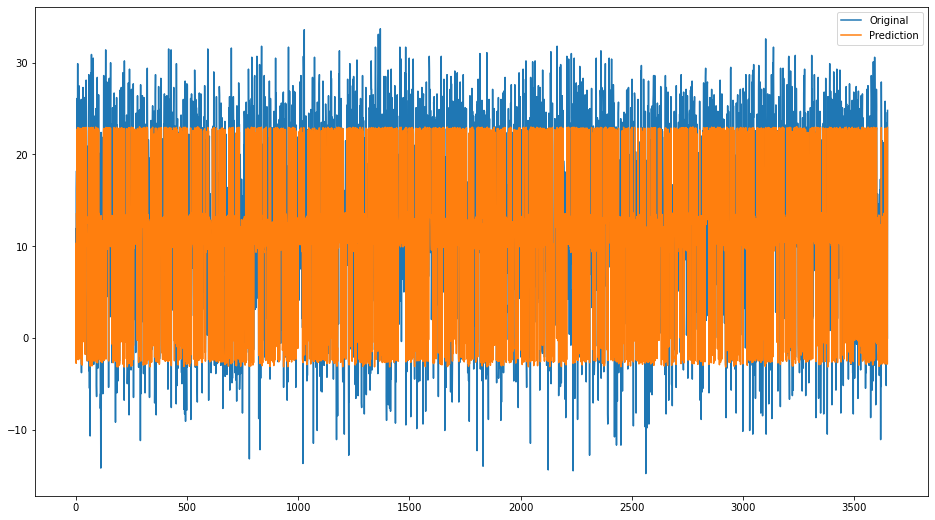

In [74]:

'''
visualization result data with graph
'''

# average
print("Average temperature")
plt.figure(figsize = (16, 9))
plt.plot(dropped_test_original_df[['O_temp_avg']], label = 'Original')
plt.plot(dropped_test_result_df[['P_temp_avg']], label = 'Prediction')
plt.legend(loc = 'upper right')
plt.show()

Maximum temperature


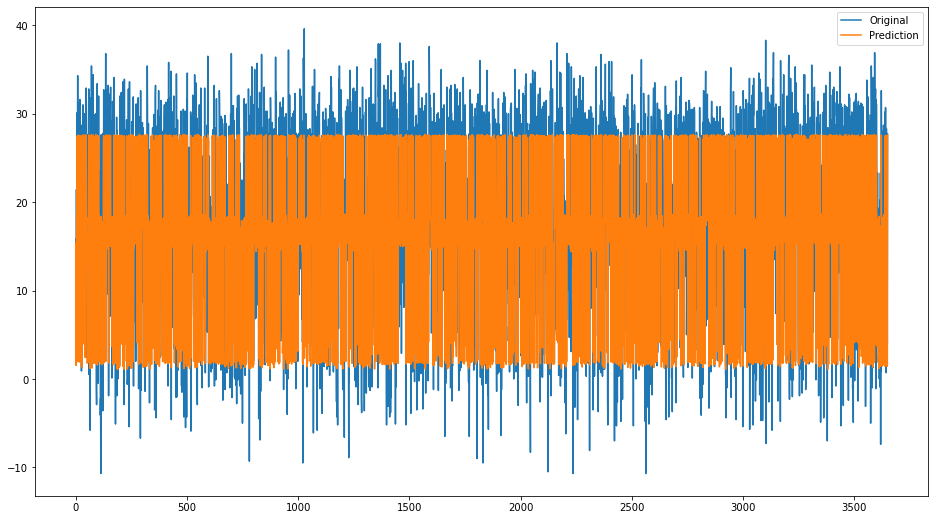

In [75]:
# maximum
print("Maximum temperature")
plt.figure(figsize = (16, 9))
plt.plot(dropped_test_original_df[['O_temp_max']], label = 'Original')
plt.plot(dropped_test_result_df[['P_temp_max']], label = 'Prediction')
plt.legend(loc = 'upper right')
plt.show()

Minimum temperature


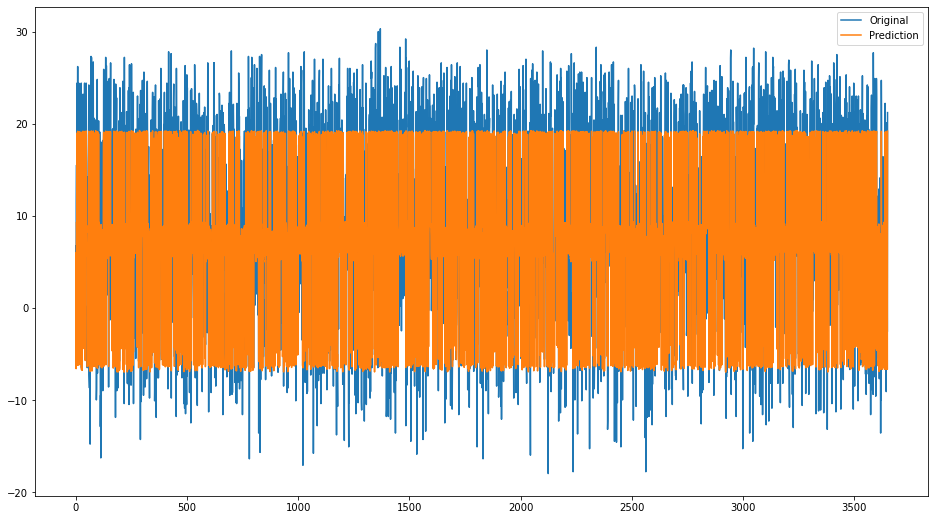

In [76]:
# minimum
print("Minimum temperature")
plt.figure(figsize = (16, 9))
plt.plot(dropped_test_original_df[['O_temp_min']], label = 'Original')
plt.plot(dropped_test_result_df[['P_temp_min']], label = 'Prediction')
plt.legend(loc = 'upper right')
plt.show()

Average temperature


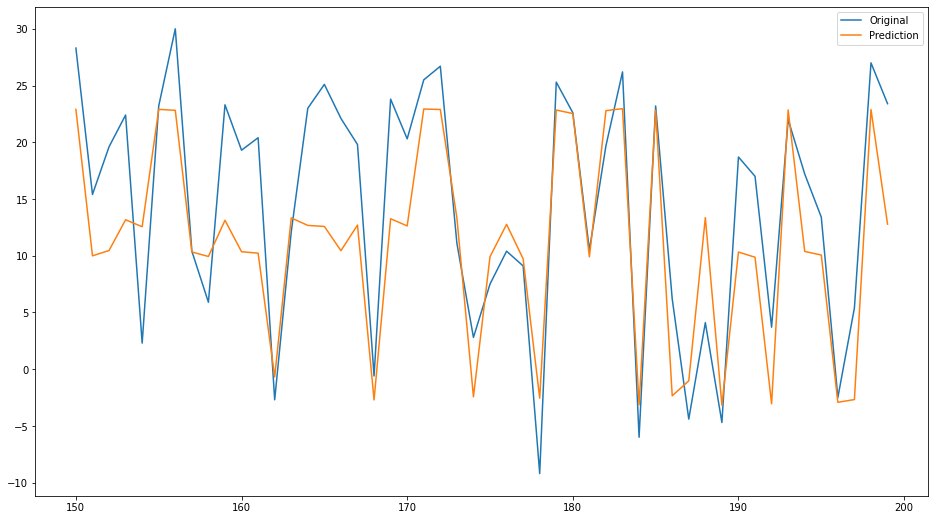

In [78]:
# average[Ni:Nj]
print("Average temperature")
plt.figure(figsize = (16, 9))
plt.plot(dropped_test_original_df[['O_temp_avg']][150:200], label = 'Original')
plt.plot(dropped_test_result_df[['P_temp_avg']][150:200], label = 'Prediction')
plt.legend(loc = 'upper right')
plt.show()